In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TidalPy.RadialSolver import radial_solver as radial_solver_new
from TidalPy.radial_solver import radial_solver as radial_solver_old
from TidalPy.utilities.graphics.multilayer import yplot
from TidalPy.rheology.models import Maxwell, Andrade, Elastic
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

run_times = True

## 1 Layer

2024-04-26 17:15:50(+00:00:04::185381) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:00(+00:00:14::580764) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:00(+00:00:14::585768) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:00(+00:00:14::591774) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:00(+00:00:14::598779) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:00(+00:00:14::604786) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

NEW


2024-04-26 17:16:01(+00:00:14::763931) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:14::769937) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:14::775942) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:14::781947) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:14::788954) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:14::794958) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:01(+00:00:15::055704) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::060708) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::066714) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::072719) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::078725) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::083729) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:01(+00:00:15::409081) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::416088) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::421093) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::427098) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::433105) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::439109) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:01(+00:00:15::698853) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::703858) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:01(+00:00:15::709864) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:15::716870) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:15::722875) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:15::728881) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:02(+00:00:15::987130) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:15::993135) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:15::998140) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::004145) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::010151) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::016156) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:02(+00:00:16::354465) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::359469) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::366475) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::372483) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::379487) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::386494) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:02(+00:00:16::647239) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::654245) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::659250) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::665255) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::671261) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:02(+00:00:16::677267) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:03(+00:00:17::004613) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::010618) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::016624) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::022629) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::028635) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::034641) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:03(+00:00:17::295405) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::301409) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::307415) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::312419) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::318425) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::324939) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:03(+00:00:17::586209) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::591213) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::597219) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::603225) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::609230) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:03(+00:00:17::615235) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:04(+00:00:17::936035) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:17::942040) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:17::948046) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:17::954051) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:17::960057) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:17::966062) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:04(+00:00:18::224827) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::229831) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::235837) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::241843) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::247847) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::253853) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:04(+00:00:18::514611) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::520616) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::526623) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::531626) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::537632) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:04(+00:00:18::543638) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:05(+00:00:18::880504) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:18::887510) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:18::894517) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:18::901522) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:18::908529) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:18::914535) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:05(+00:00:19::205892) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::211898) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::217904) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::223908) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::229914) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::236921) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

2024-04-26 17:16:05(+00:00:19::501161) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::507168) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::513172) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::553208) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::562217) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
2024-04-26 17:16:05(+00:00:19::575229) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra car

6.49 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
OLD
200 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Old size: (6, 100); new: (6, 100).


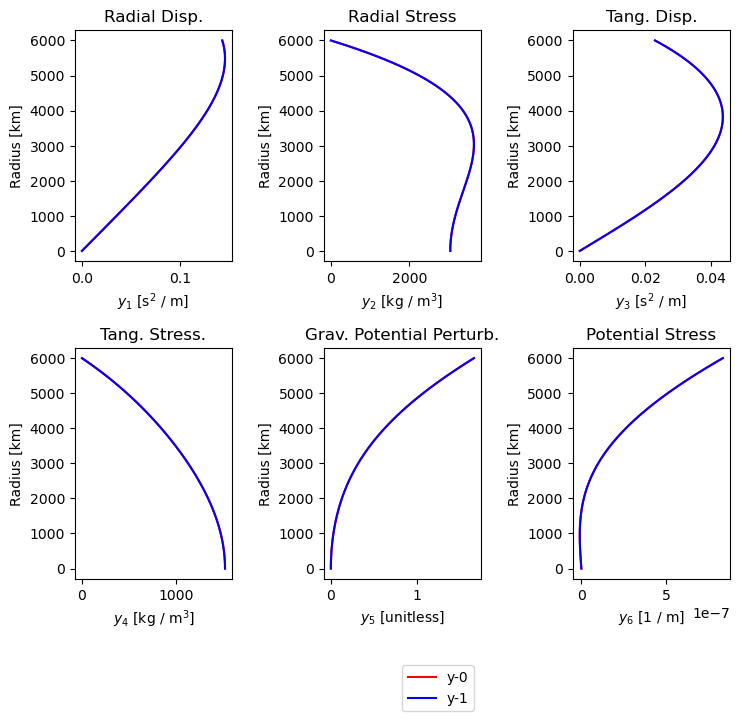

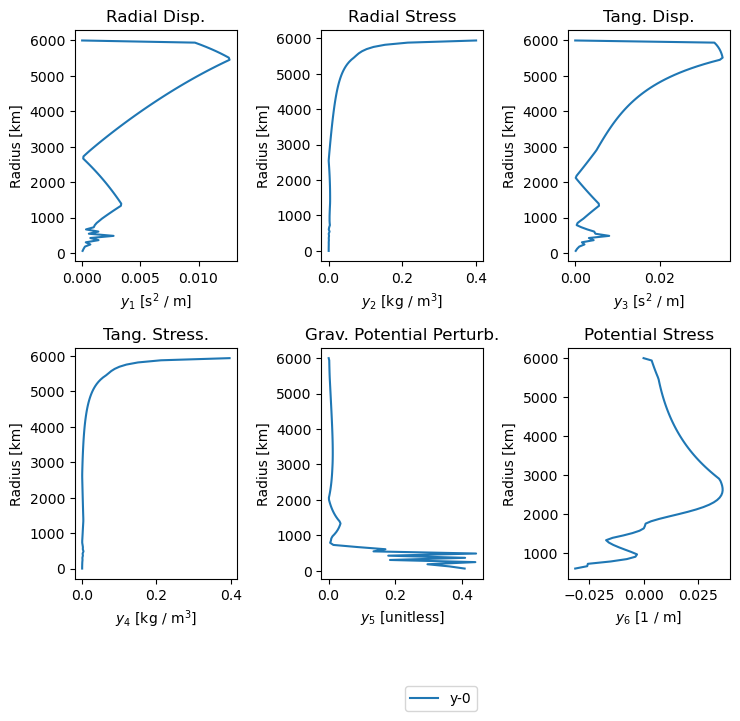

0j


In [2]:
def test_1layer():
    frequency = np.pi * 2. / (86400. * 7.5)
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    indices_by_layer = radius_array > 0.
    density_array = np.ones_like(radius_array) * 5400.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    viscosity_array = np.ones_like(radius_array) * 1.0e18

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=('solid',),
        is_static_by_layer=(False,),
        is_incompressible_by_layer=(False,),
        upper_radius_by_layer=(radius_array[-1],),
        degree_l = 2,
        solve_for = None,
        use_kamata = False,
        integration_method = 'DOP853',
        integration_rtol = 1.0e-9,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = False,
        max_num_steps = 500_000,
        expected_size = 500,
        max_ram_MB = 500,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=(True,),
        is_static_by_layer=(False,),
        indices_by_layer=(indices_by_layer,),
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = False,
        integration_method = 'DOP853',
        integrator = 'scipy',
        integration_rtol = 1.0e-9,
        integration_atol = 1.0e-12,
        nondimensionalize = False,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)
    
    if run_times:
        print("NEW")
        %timeit radial_solver_new(**input_new_dict)

        print("OLD")
        %timeit radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_1layer()

# 2 Layers

NEW
3.58 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
OLD
96.3 ms ± 764 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Old size: (6, 100); new: (6, 100).


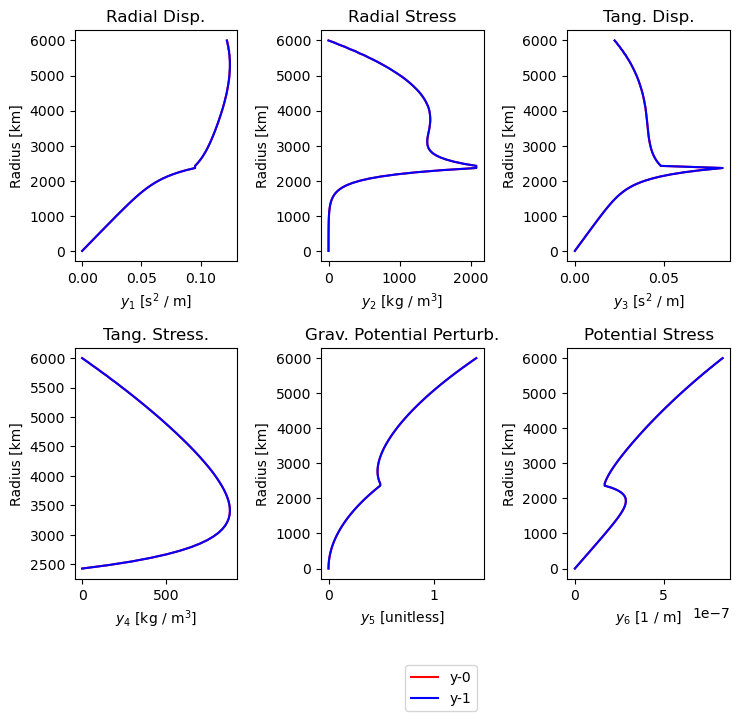

C:\Users\joepr\AppData\Local\Temp\ipykernel_13616\10381807.py:107: RuntimeWarning: invalid value encountered in divide
  percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)


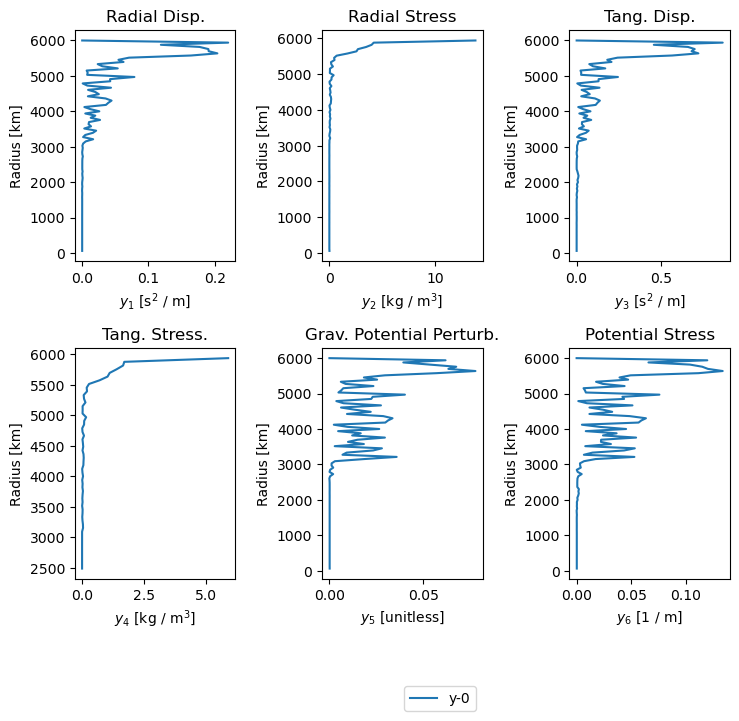

(2.886579864025407e-12-4.5102810375396984e-14j)


In [3]:
def test_2layer():
    layer_types = ('liquid', 'solid')
    is_solid_by_layer = (False, True)
    is_static_by_layer = (False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-10
    nondimensionalize = True
    is_incompressible_by_layer = (False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    CMB_radius = 0.4 * radius_array[-1]
    upper_radius_by_layer = (CMB_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.3)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, mantle_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 11000.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 5.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = nondimensionalize,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = nondimensionalize,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)
    
    if run_times:
        print("NEW")
        %timeit radial_solver_new(**input_new_dict)

        print("OLD")
        %timeit radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_2layer()

## 3 Layers

NEW
2.38 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
OLD
100 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


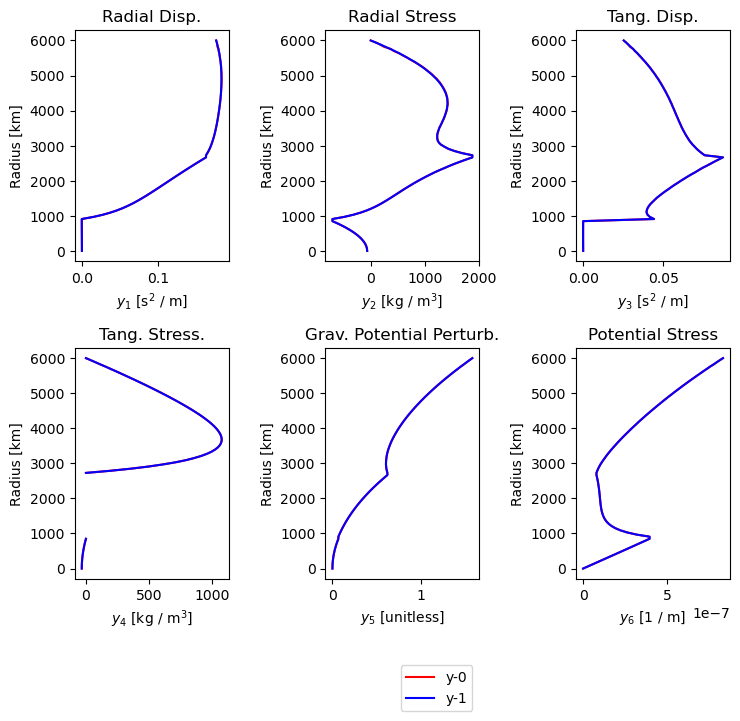

C:\Users\joepr\AppData\Local\Temp\ipykernel_13616\4154141096.py:114: RuntimeWarning: invalid value encountered in divide
  percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)


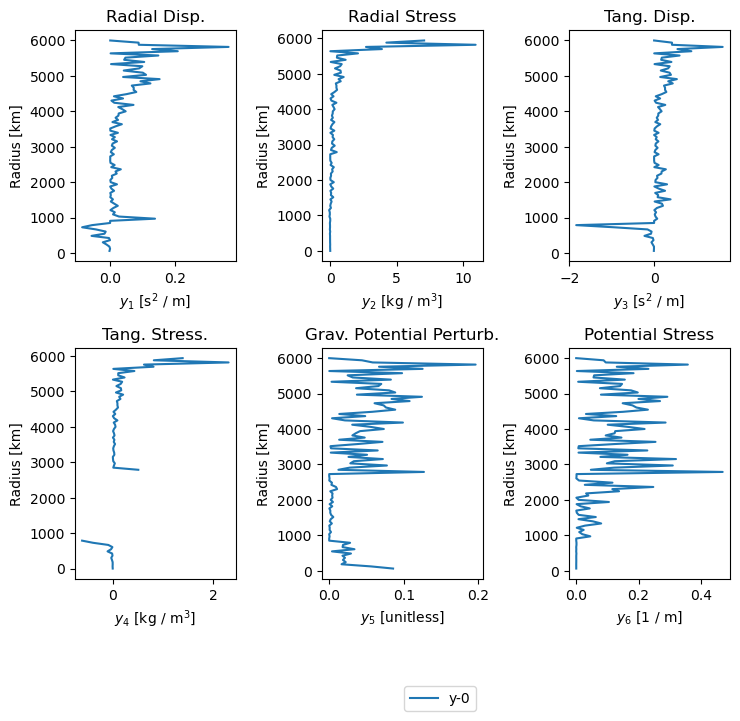

In [4]:
def test_3layer():
    layer_types = ('solid', 'liquid', 'solid')
    is_solid_by_layer = (True, False, True)
    is_static_by_layer = (False, False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-10
    nondimensionalize = True
    is_incompressible_by_layer = (False, False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    ICB_radius = 0.15 * radius_array[-1]
    CMB_radius = 0.45 * radius_array[-1]
    upper_radius_by_layer = (ICB_radius, CMB_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.1)
    
    ic_index = radius_array <= ICB_radius
    oc_index = np.logical_and(radius_array > ICB_radius, radius_array <= CMB_radius)
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, oc_index, mantle_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 9600.
    density_array[oc_index] = 8000.
    
    planet_bulk_density = np.average(density_array)
    
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 10.0e11
    bulk_modulus_array[oc_index] = 5.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 150.0e9
    shear_array[oc_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1.0e27
    viscosity_array[oc_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = nondimensionalize,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = nondimensionalize,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)
    
    if run_times:
        print("NEW")
        %timeit radial_solver_new(**input_new_dict)

        print("OLD")
        %timeit radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

test_3layer()

## 4 Layers (Low Density Liquid)

NEW
11.5 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
OLD
260 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


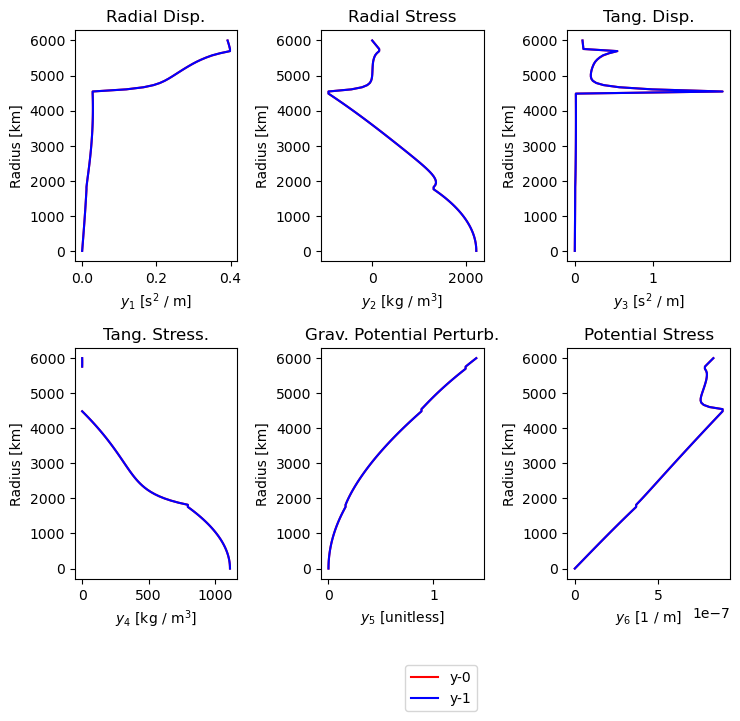

C:\Users\joepr\AppData\Local\Temp\ipykernel_13616\2015884643.py:122: RuntimeWarning: invalid value encountered in divide
  percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)


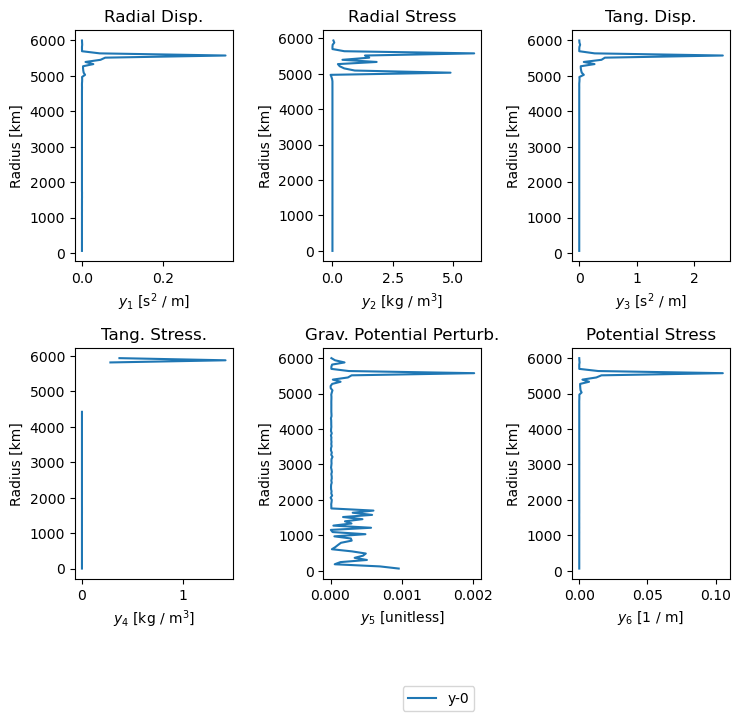

In [6]:
def test_4layer():
    layer_types = ('solid', 'solid', 'liquid', 'solid')
    is_solid_by_layer = (True, True, False, True)
    is_static_by_layer = (False, False, False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-12
    integration_atol = 1.0e-15
    nondimensionalize = True
    is_incompressible_by_layer = (False, False, False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    CMB_radius = 0.3 * radius_array[-1]
    ocean_radius = 0.75 * radius_array[-1]
    ice_radius = 0.95 * radius_array[-1]
    upper_radius_by_layer = (CMB_radius, ocean_radius, ice_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.5)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = np.logical_and(radius_array > CMB_radius, radius_array <= ocean_radius)
    ocean_index = np.logical_and(radius_array > ocean_radius, radius_array <= ice_radius)
    ice_index = radius_array > ice_radius
    
    indices_by_layer = (ic_index, mantle_index, ocean_index, ice_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 9600.
    density_array[ocean_index] = 1000.
    density_array[ice_index] = 920.
    
    planet_bulk_density = np.average(density_array)
    
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 10.0e11
    bulk_modulus_array[ocean_index] = 2.2e9
    bulk_modulus_array[ice_index] = 5.0e11
    
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 150.0e9
    shear_array[ocean_index] = 0.0
    shear_array[ice_index] = 3.0e9
    
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1.0e27
    viscosity_array[ocean_index] = 1000.
    viscosity_array[ice_index] = 1.0e14

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = nondimensionalize,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = nondimensionalize,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)
    
    if run_times:
        print("NEW")
        %timeit radial_solver_new(**input_new_dict)

        print("OLD")
        %timeit radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

test_4layer()